# QC: preprocess, filtering, normalization, log tansform

### Documention

In [520]:
# https://nbisweden.github.io/excelerate-scRNAseq/session-qc/Quality_control.html

## Load packages

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np

## Load the h5ad Data Object containing the counts and annotations

In [2]:
##cell before produces an error therefore I simply read the file here
#combined_adata = ad.read_h5ad('/storage/users/data/PANC/combined_adata.h5ad')
combined_adata = ad.read_h5ad('/storage/users/data/PANC/combined_adata.h5ad')

In [3]:
print(combined_adata.obs['condition'])

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAACGCTTCAGCCTCT-1         CTRL_1
                         ...     
TTTACTGTCATTACTC-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 11919, dtype: category
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']


In [4]:
print(combined_adata)

AnnData object with n_obs × n_vars = 11919 × 36613
    obs: 'condition'


## QC: preprcoess, filtering, normalization

### Calculate several QC metrics that will be stored in the adata Object

In [5]:
sc.pp.calculate_qc_metrics(combined_adata, inplace=True)
print(combined_adata)

AnnData object with n_obs × n_vars = 11919 × 36613
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


### CMO tag filtering

In [6]:
# Identify CMO tags (or other spike-ins)
combined_adata.var["CMO"] = combined_adata.var_names.str.contains("CMO")

In [7]:
# Get Percentage of CMOs in cells
# Filter the Data for CMO Tags
cmo_data = combined_adata[:, combined_adata.var["CMO"].values].X
# Calculate the Percentage:
cmo_counts_per_cell = cmo_data.sum(axis=1)
total_counts_per_cell = combined_adata.X.sum(axis=1)
pct_cmo_per_cell = (cmo_counts_per_cell / total_counts_per_cell) * 100
# Add to the obs DataFrame:
combined_adata.obs["pct_cmo"] = pct_cmo_per_cell
print(combined_adata.obs["pct_cmo"])

barcode
AAACCCAGTAGGCTCC-1    24.628355
AAACCCAGTCGCAACC-1    34.891727
AAACCCATCCACAAGT-1    23.580470
AAACGCTTCACTACGA-1    23.367459
AAACGCTTCAGCCTCT-1    24.847910
                        ...    
TTTACTGTCATTACTC-1    29.620835
TTTCACAGTGATATAG-1    12.793065
TTTCACATCGATGCAT-1    50.637605
TTTCATGTCCCTCTAG-1    46.113246
TTTGACTGTTCCGGTG-1    31.137191
Name: pct_cmo, Length: 11919, dtype: float64


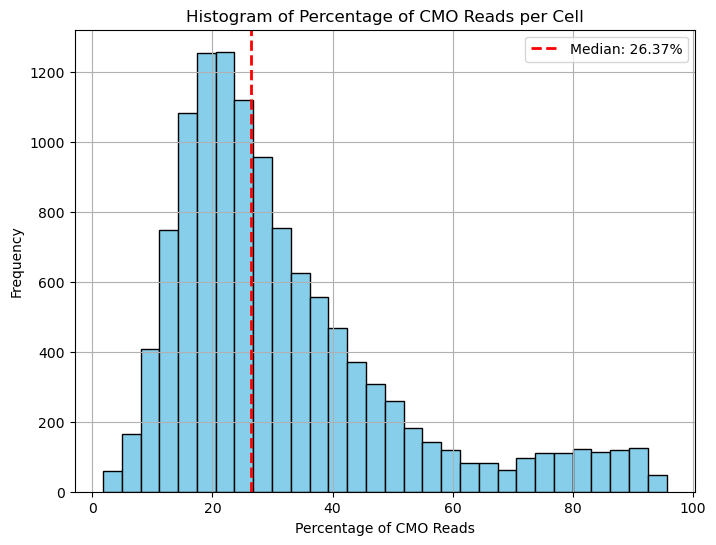

(26.368159203980102, 9.218793933183218)

In [8]:
pct_cmo_per_cell = combined_adata.obs["pct_cmo"]
# Calculate median and mean absolute deviation (MAD)
median_pct_cmo = np.median(pct_cmo_per_cell)
mad_pct_cmo = np.median(np.abs(pct_cmo_per_cell - median_pct_cmo))

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(pct_cmo_per_cell, bins=30, color='skyblue', edgecolor='black')
plt.axvline(median_pct_cmo, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_pct_cmo:.2f}%')
plt.title('Histogram of Percentage of CMO Reads per Cell')
plt.xlabel('Percentage of CMO Reads')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show plot and the median and MAD
plt.show()

median_pct_cmo, mad_pct_cmo


In [9]:
### Remove CMO tags

In [10]:
combined_adata.var["CMO"]

feature_id
ENSG00000243485    False
ENSG00000237613    False
ENSG00000186092    False
ENSG00000238009    False
ENSG00000239945    False
                   ...  
CMO308              True
CMO309              True
CMO310              True
CMO311              True
CMO312              True
Name: CMO, Length: 36613, dtype: bool

In [11]:
combined_adata = combined_adata[:, ~combined_adata.var["CMO"].values]

In [12]:
combined_adata.var["CMO"]

feature_id
ENSG00000243485    False
ENSG00000237613    False
ENSG00000186092    False
ENSG00000238009    False
ENSG00000239945    False
                   ...  
ENSG00000277836    False
ENSG00000278633    False
ENSG00000276017    False
ENSG00000278817    False
ENSG00000277196    False
Name: CMO, Length: 36601, dtype: bool

### Mitochondrial and Ribosomal Gene Filtering

#### Create dictionary ensembl2symbol

In [13]:
from biomart import BiomartServer

In [14]:
# Connect to the BioMart server
server = BiomartServer("http://ensembl.org/biomart")

# Select the human genes dataset
dataset = server.datasets['hsapiens_gene_ensembl']

# Query BioMart to get the translation from Ensembl ID to gene symbol
response = dataset.search({
    'attributes': ['ensembl_gene_id', 'external_gene_name'],
})

# Initialize an empty dictionary to store the mapping
ensembl_to_gene_name = {}

# Iterate through the response lines
for line in response.iter_lines():
    # Decode the line and split it into Ensembl ID and gene name
    decoded_line = line.decode('utf-8')
    ensembl_id, gene_name = decoded_line.split('\t')
    
    # Store the mapping in the dictionary
    ensembl_to_gene_name[ensembl_id] = gene_name

# Now, ensembl_to_gene_name is a dictionary with Ensembl IDs as keys and gene names as values.


#### Add gene symbol to combined_adata object

##### 1. variant

In [15]:
# Assuming ensembl_to_gene_name is a dictionary where the keys are Ensembl IDs and the values are gene symbols
combined_adata.var["gene_symbol"] = combined_adata.var_names.map(ensembl_to_gene_name)

/tmp/ipykernel_3273533/4005644185.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  combined_adata.var["gene_symbol"] = combined_adata.var_names.map(ensembl_to_gene_name)


##### 2. variant

In [16]:
# Extracting the Ensembl IDs from the var_names
ensembl_ids = combined_adata.var_names.tolist()

# Mapping the Ensembl IDs to gene symbols using the provided dictionary
gene_symbols = [ensembl_to_gene_name[ensembl_id] if ensembl_id in ensembl_to_gene_name else 'unknown' for ensembl_id in ensembl_ids]

# Adding the gene symbols to combined_adata.var
combined_adata.var["gene_symbol"] = gene_symbols

In [17]:
combined_adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000274175', 'ENSG00000275869', 'ENSG00000273554',
       'ENSG00000278782', 'ENSG00000277761', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', name='feature_id', length=36601)

In [18]:
combined_adata.var["gene_symbol"]

feature_id
ENSG00000243485    MIR1302-2HG
ENSG00000237613        FAM138A
ENSG00000186092          OR4F5
ENSG00000238009               
ENSG00000239945               
                      ...     
ENSG00000277836               
ENSG00000278633               
ENSG00000276017               
ENSG00000278817               
ENSG00000277196               
Name: gene_symbol, Length: 36601, dtype: object

In [19]:
combined_adata

AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol'

#### Analyze Mito and Ribo Genes

In [20]:
# After loading your data, identify mitochondrial and ribosomal genes
#combined_adata.var["mito"] = combined_adata.var_names.str.startswith("MT-") | combined_adata.var_names.str.startswith("mt-")
#combined_adata.var["ribo"] = combined_adata.var_names.str.startswith("RPS") | combined_adata.var_names.str.startswith("RPL")

# Using the gene_symbol column to identify mitochondrial and ribosomal genes
combined_adata.var["mito"] = combined_adata.var["gene_symbol"].str.startswith("MT-") | combined_adata.var["gene_symbol"].str.startswith("mt-")
combined_adata.var["ribo"] = combined_adata.var["gene_symbol"].str.startswith("RPS]") | combined_adata.var["gene_symbol"].str.startswith("RPL")


#### Compute QC metrics, considering both mitochondrial and ribosomal genes

In [21]:
# Compute QC metrics, considering both mitochondrial and ribosomal genes
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=["mito", "ribo"], percent_top=None, inplace=True)

In [22]:
combined_adata.var["mito"]

feature_id
ENSG00000243485    False
ENSG00000237613    False
ENSG00000186092    False
ENSG00000238009    False
ENSG00000239945    False
                   ...  
ENSG00000277836    False
ENSG00000278633    False
ENSG00000276017    False
ENSG00000278817    False
ENSG00000277196    False
Name: mito, Length: 36601, dtype: bool

In [23]:
mito_genes = combined_adata[:, combined_adata.var["mito"].values]
mito_genes

View of AnnData object with n_obs × n_vars = 11919 × 13
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo'

In [24]:
# Get a list of the newly annotated adata object and the Mitochondrial count
print(combined_adata)
combined_adata.obs.pct_counts_mito


AnnData object with n_obs × n_vars = 11919 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo'


barcode
AAACCCAGTAGGCTCC-1    2.144417
AAACCCAGTCGCAACC-1    1.871827
AAACCCATCCACAAGT-1    1.433304
AAACGCTTCACTACGA-1    2.549500
AAACGCTTCAGCCTCT-1    2.505463
                        ...   
TTTACTGTCATTACTC-1    2.388475
TTTCACAGTGATATAG-1    2.521221
TTTCACATCGATGCAT-1    1.648956
TTTCATGTCCCTCTAG-1    1.987448
TTTGACTGTTCCGGTG-1    1.839445
Name: pct_counts_mito, Length: 11919, dtype: float64

In [25]:
# Sort the cells by Percentage Mitochondrium and order by highest percentage first
sorted_adata = combined_adata[combined_adata.obs['pct_counts_mito'].sort_values(ascending=False).index]
sorted_adata.obs.pct_counts_mito

barcode
TCCCAGTGTATTAAGG-1    96.745152
TATTGGGGTAGGAAAG-1    96.578906
TCATTACCACGACGCT-1    95.793935
TACCCGTTCCGAGGCT-1    95.497111
GACCGTGCACGCTTAA-1    95.034890
                        ...    
ACAAGCTTCGTTCTCG-1     0.033714
TTGTTTGAGAGTGTTA-1     0.027454
GTGGGAATCGAGTTGT-1     0.025947
TCCTGCACATTGAAAG-1     0.011808
CATACCCTCAACTCTT-1     0.011618
Name: pct_counts_mito, Length: 11919, dtype: float64

#### Visualize cell's mitchondrial and ribosomal gene expression

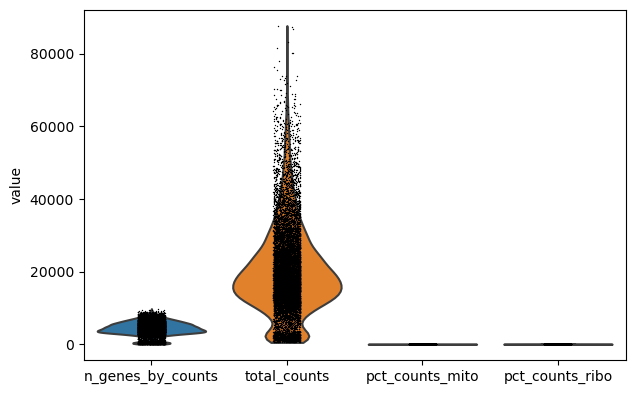

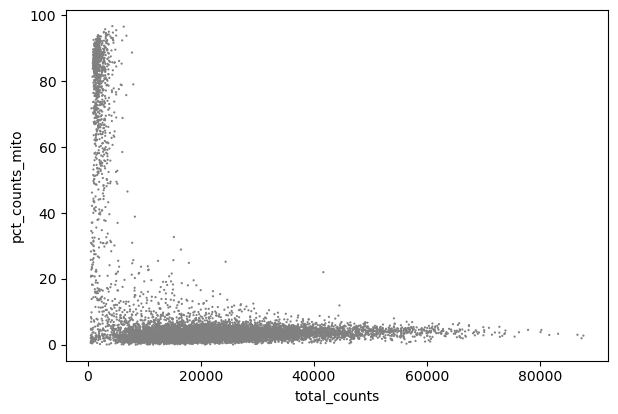

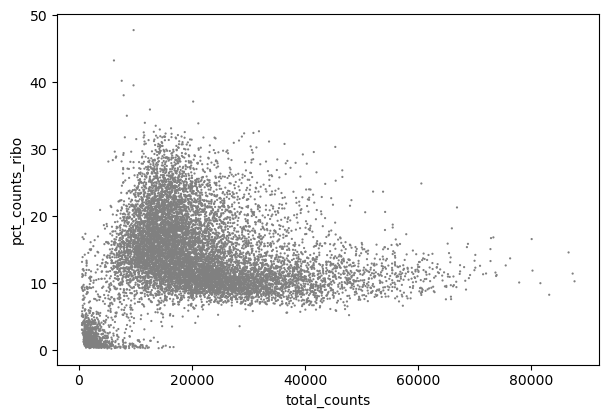

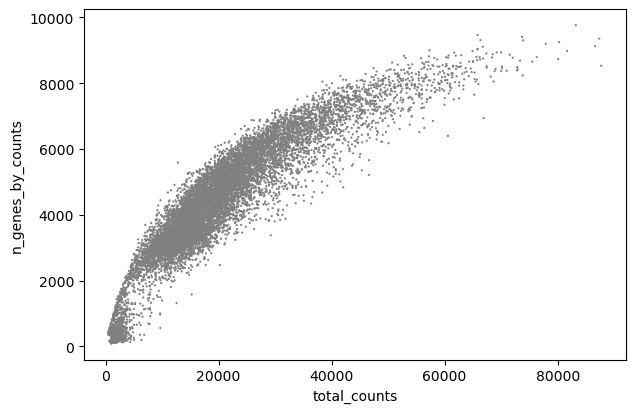

In [26]:
# Visualize basic QC metrics, including ribosomal content:
sc.pl.violin(combined_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'])
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_mito')
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_ribo')
sc.pl.scatter(combined_adata, x='total_counts', y='n_genes_by_counts')



#### Filter Mito and Ribo accoridng to a certain percentag (e.g. 10 and 30%)

In [27]:
# Filter cells based on mitochondrial and ribosomal content:
# Cells with high mitochondrial gene expression might be undergoing apoptosis, so you might want to exclude them.
combined_adata = combined_adata[combined_adata.obs.pct_counts_mito < 10, :]
# high levels of ribosomal RNA (rRNA) can indicate incomplete poly-A tail capture or contamination. Thus, by filtering out cells with excessive ribosomal transcripts, we're likely removing lower-quality cells.
combined_adata = combined_adata[combined_adata.obs.pct_counts_ribo < 30, :]

#### Filter mitochondrial genes directly

In [28]:
# If you want to subsequently filter out these genes, you can do so as follows:
#mito_ribo_genes = combined_adata.var["mito"] | combined_adata.var["ribo"]
#combined_adata = combined_adata[:, ~mito_ribo_genes]

### Min and max gene count per cell filtering

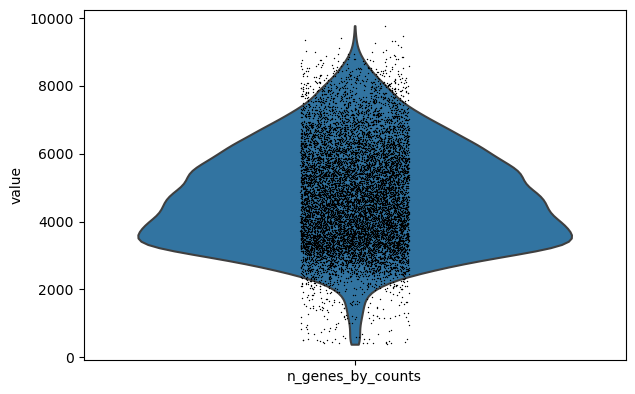

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

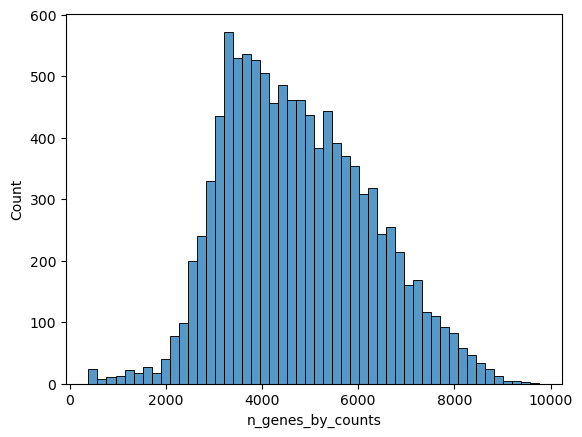

In [29]:
# In single-cell RNA sequencing (scRNA-seq) analysis, filtering based on the number of expressed genes (n_genes_by_counts) per cell is a crucial quality control step. Here's why you might want to apply these cutoffs and how to determine the appropriate values:
# Why Apply Min and Max Cutoffs?
## Low-quality cells: Cells with an extremely low number of expressed genes might be low-quality cells, dead cells, or empty droplets that were mistakenly captured during the experiment. These can introduce noise into the dataset.

## Doublets or Multiplets: Cells with an abnormally high number of expressed genes might be doublets (or multiplets) where two or more cells have been mistakenly captured and sequenced as one. These can distort downstream analyses, especially in clustering or differentiation studies.

## Outliers: Extremely high or low gene counts might indicate outlier cells that could bias downstream analyses.

# Visualize the number of genes per cell
sc.pl.violin(combined_adata, keys=['n_genes_by_counts'], jitter=True, log=False)

import seaborn as sns
sns.histplot(combined_adata.obs['n_genes_by_counts'], bins=50)

In [30]:
# Set thresholds based on the previous scatter plots, removing low-quality cells and potential doublets.
mincount = 1800; 
maxcount = 10000; 
#mincount = combined_adata.obs['n_genes_by_counts'].quantile(0.01)
#maxcount = combined_adata.obs['n_genes_by_counts'].quantile(0.99)
#mincount
#maxcount

In [31]:
#sc.pp.filter_cells(combined_adata, min_counts=1000)
combined_adata = combined_adata[combined_adata.obs.n_genes_by_counts > mincount, :]
combined_adata = combined_adata[combined_adata.obs.n_genes_by_counts < maxcount, :]

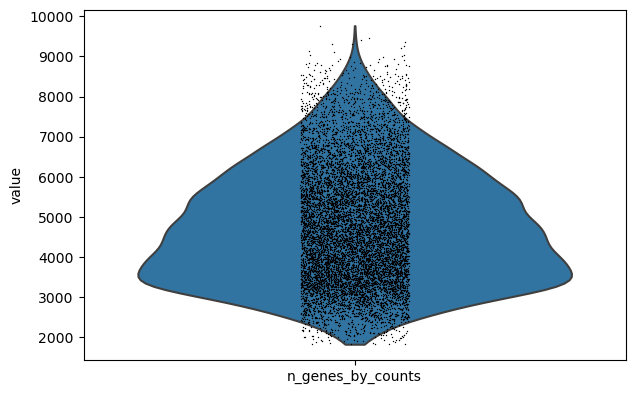

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

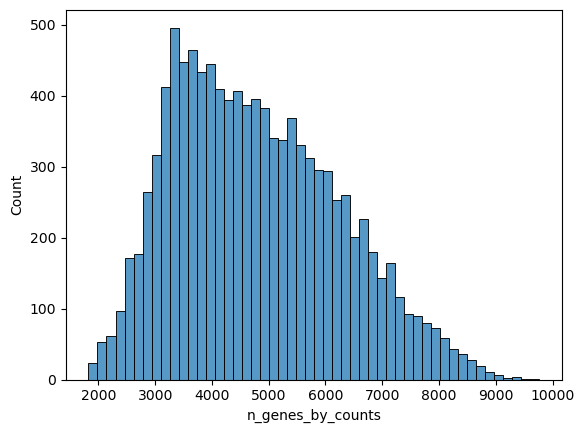

In [32]:
sc.pl.violin(combined_adata, keys=['n_genes_by_counts'], jitter=True, log=False)
sns.histplot(combined_adata.obs['n_genes_by_counts'], bins=50)

### Min and max total transcript count per cell filtering

In [33]:
# filtering based on total_counts is also common in single-cell RNA sequencing (scRNA-seq) quality control, and it's analogous to filtering based on n_genes_by_counts.
# Why Apply Min and Max Cutoffs on total_counts?
## Low-quality cells: Cells with very low total_counts can indicate cells with poor-quality RNA, dying cells, or cells with limited RNA content. They might also represent empty droplets or ambient RNA in droplet-based technologies like 10x Genomics.
## Doublets or Multiplets: An abnormally high total_counts might indicate doublets or multiplets, where two or more cells got captured together.
## Standardizing Sequencing Depth: While downstream normalization methods often account for differences in sequencing depth, extreme outliers can still introduce biases.

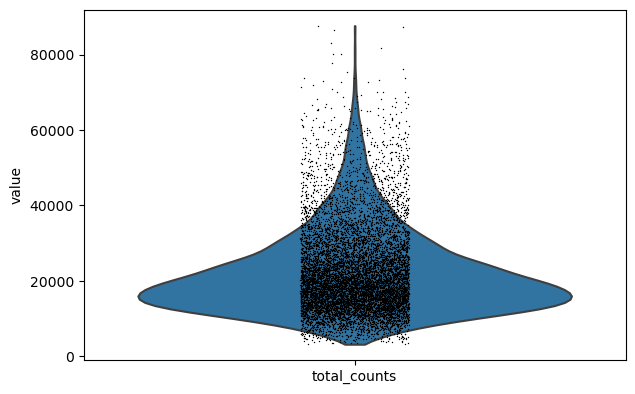

<Axes: xlabel='total_counts', ylabel='Count'>

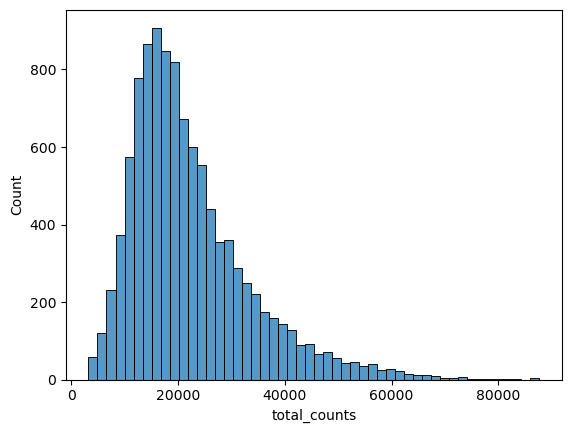

In [34]:
# Histogram or Violin Plot: A visual inspection can help identify outliers or bimodal distributions.
sc.pl.violin(combined_adata, keys=['total_counts'], jitter=True, log=False)
    
import seaborn as sns
sns.histplot(combined_adata.obs['total_counts'], bins=50)

In [35]:
mincount = 0; 
maxcount = 80000; 
#mincount = combined_adata.obs['total_counts'].quantile(0.01)
#maxcount = combined_adata.obs['total_counts'].quantile(0.99)
maxcount

80000

In [36]:
#sc.pp.filter_cells(combined_adata, min_counts=1000)
combined_adata = combined_adata[combined_adata.obs.total_counts > mincount, :]
combined_adata = combined_adata[combined_adata.obs.total_counts < maxcount, :]

<Axes: xlabel='total_counts', ylabel='Count'>

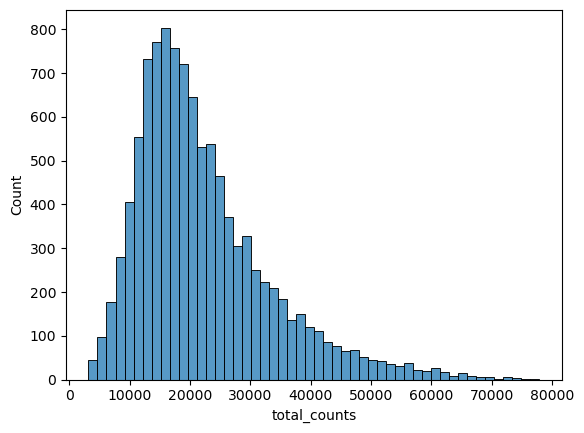

In [37]:
sns.histplot(combined_adata.obs['total_counts'], bins=50)

### UMI and gene count filter (n_gene|UMI_by_counts, total UMI per cell)

In [41]:
# Assuming combined_adata has a 'condition' column in .obs
conditions = combined_adata.obs['condition'].unique()

# Using the gene_symbol column to identify mitochondrial and ribosomal genes and hemoglobin genes
combined_adata.var["mito"] = combined_adata.var["gene_symbol"].str.startswith("MT-") | combined_adata.var["gene_symbol"].str.startswith("mt-")
combined_adata.var["ribo"] = combined_adata.var["gene_symbol"].str.startswith("RPS") | combined_adata.var["gene_symbol"].str.startswith("RPL")
combined_adata.var["hemo"] = combined_adata.var["gene_symbol"].str.startswith("HBB") | \
                             combined_adata.var["gene_symbol"].str.startswith("HBA") | \
                             combined_adata.var["gene_symbol"].str.startswith("HBM") | \
                             combined_adata.var["gene_symbol"].str.startswith("HBD")

In [42]:
combined_adata

AnnData object with n_obs × n_vars = 10594 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_umi', 'total_counts_hemo', 'log1p_total_counts_hemo', 'pct_counts_hemo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'hemo'

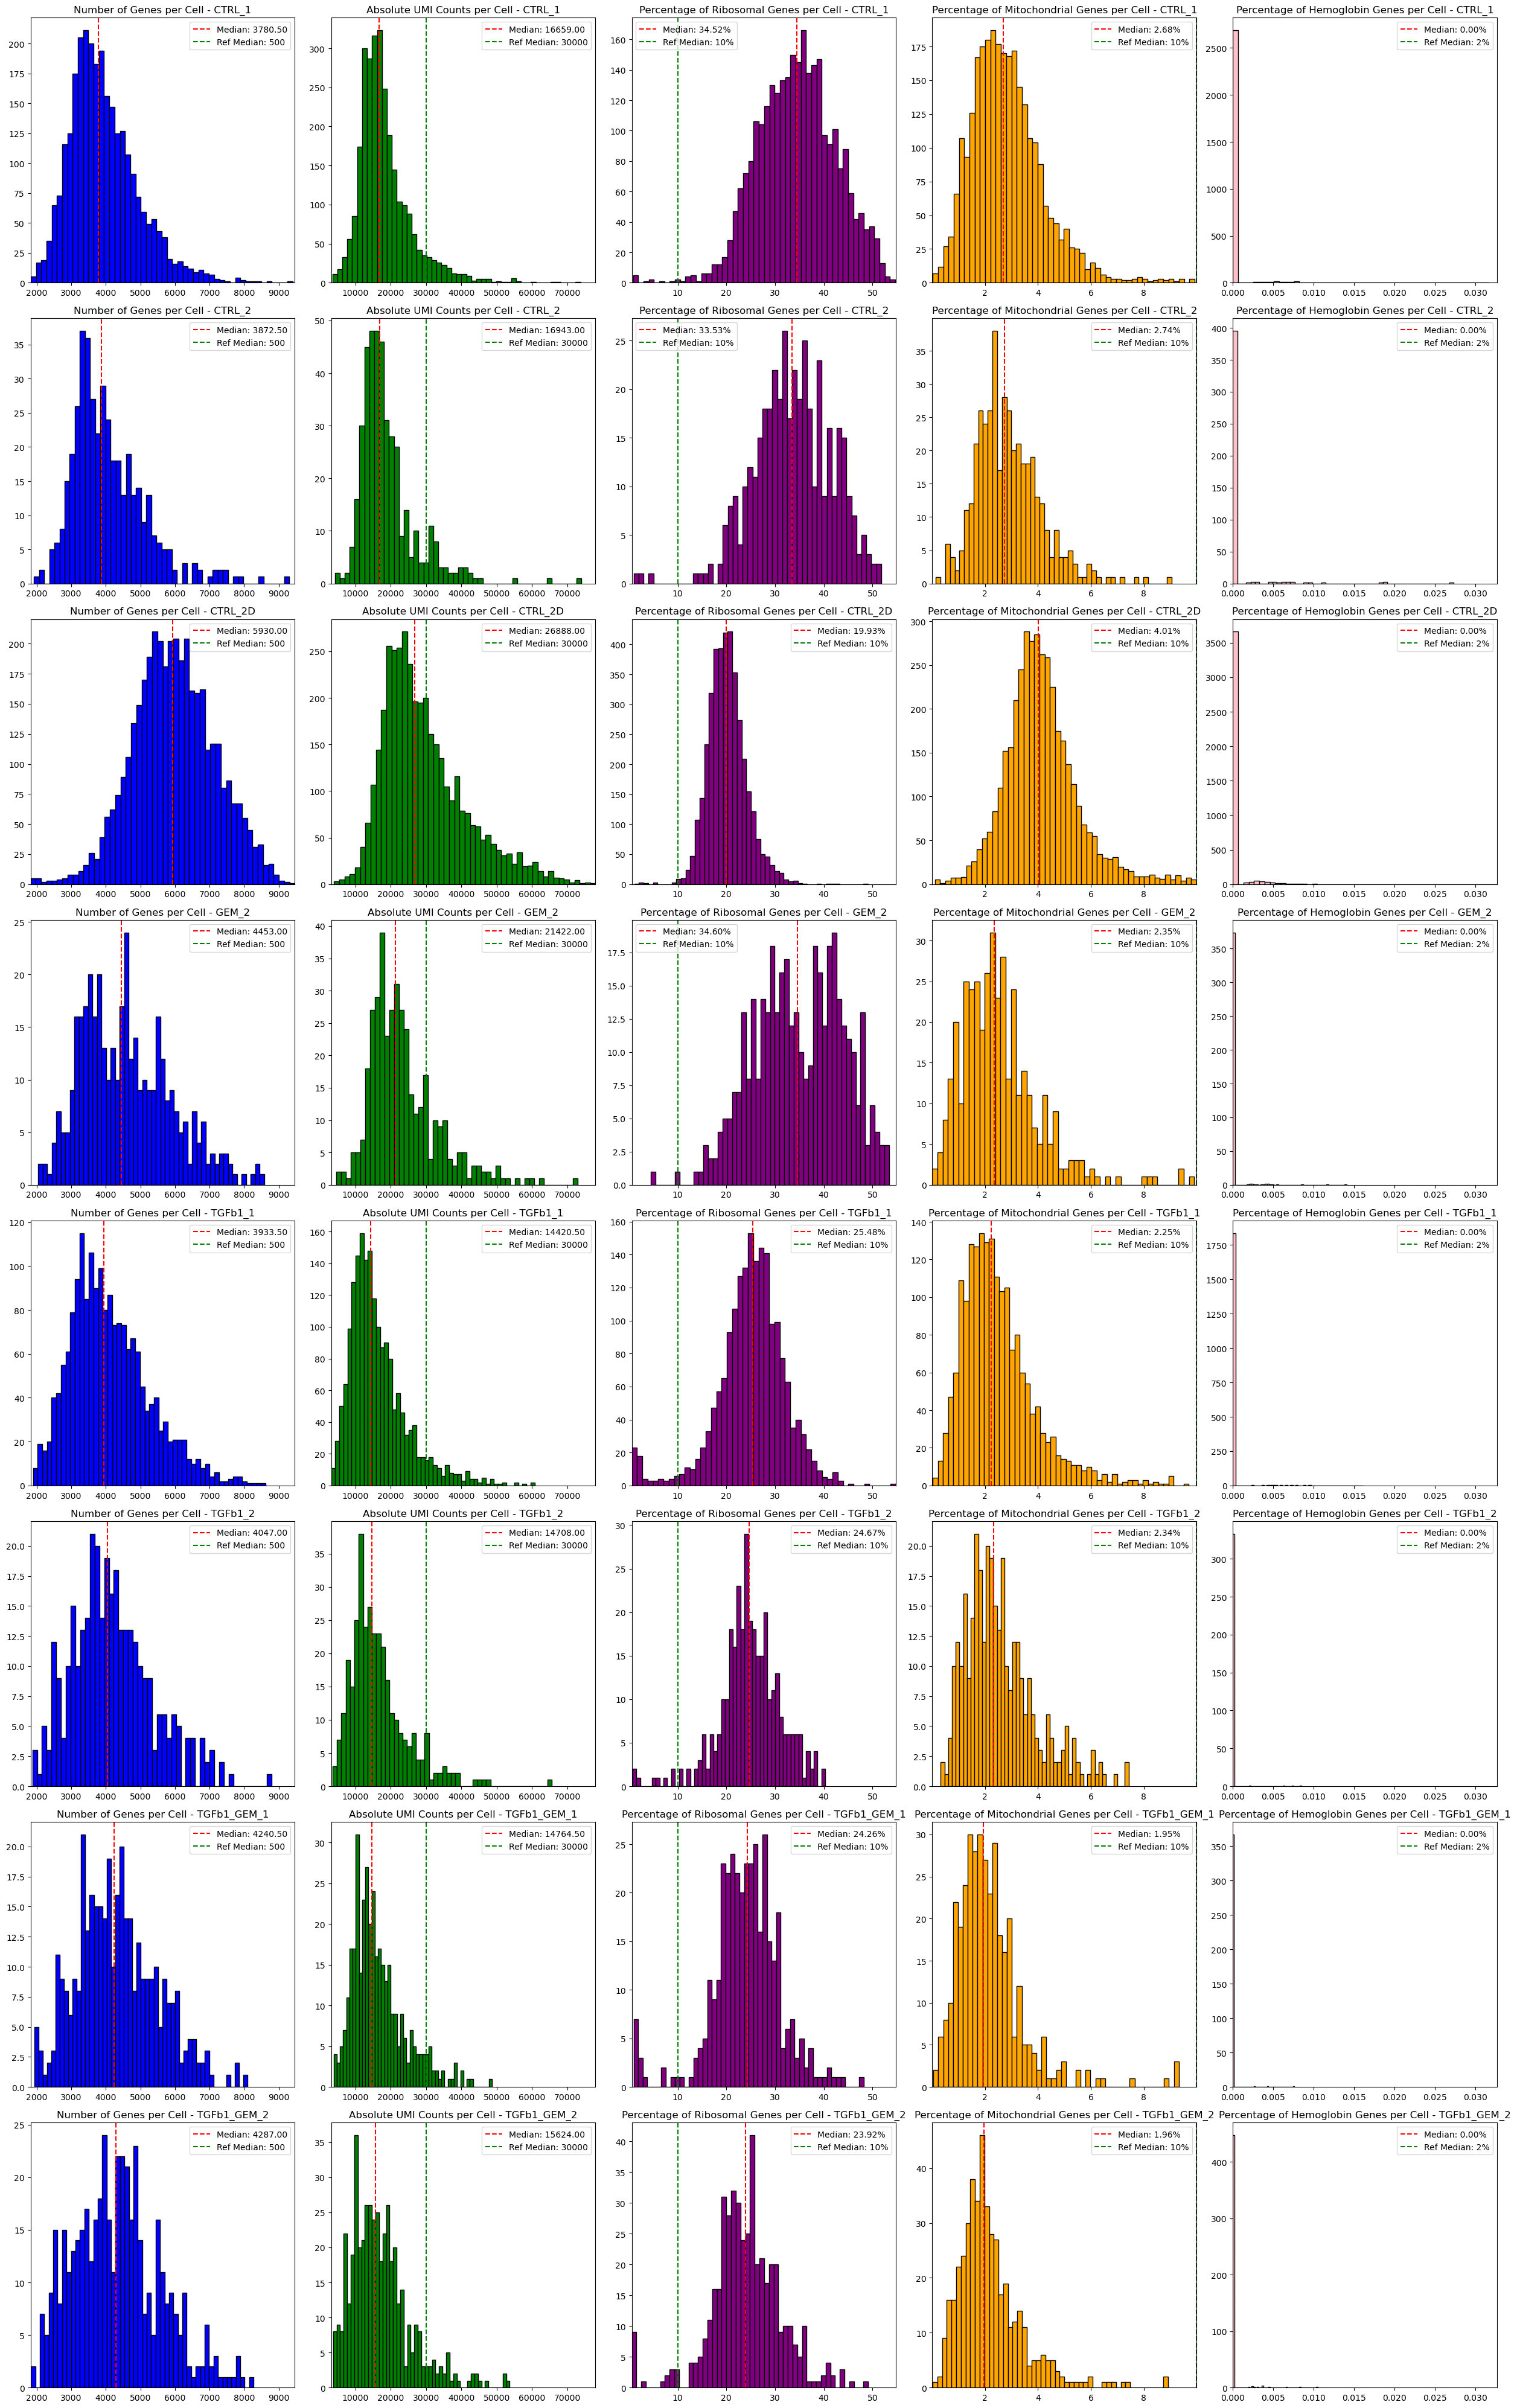

In [47]:
# Compute QC metrics, considering mitochondrial, ribosomal, and hemoglobin genes
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=["mito", "ribo", "hemo"], percent_top=None, inplace=True)

# Add the necessary fields to obs, extracted from the QC calculation
combined_adata.obs['n_genes'] = combined_adata.obs['n_genes_by_counts']  # Number of detected genes
combined_adata.obs['n_umi'] = combined_adata.obs['total_counts']         # Total UMI counts (absolute RNA molecule counts)

# Define reference median values
ref_median_umi = 30000
ref_median_genes = 500
ref_median_total_umi_counts = 30000
ref_median_pct_ribo = 10  # % of ribosomal genes
ref_median_pct_mito = 10  # % of mitochondrial genes
ref_median_pct_hemo = 2   # % of hemoglobin genes

# Set up the grid for plotting
fig, axes = plt.subplots(len(conditions), 5, figsize=(25, 5 * len(conditions)))

# Calculate the max and min values for each plot column to normalize x-axis across conditions
max_n_genes = combined_adata.obs['n_genes'].max()
min_n_genes = combined_adata.obs['n_genes'].min()

max_n_umi = combined_adata.obs['n_umi'].max()
min_n_umi = combined_adata.obs['n_umi'].min()

max_pct_ribo = combined_adata.obs['pct_counts_ribo'].max()
min_pct_ribo = combined_adata.obs['pct_counts_ribo'].min()

max_pct_mito = combined_adata.obs['pct_counts_mito'].max()
min_pct_mito = combined_adata.obs['pct_counts_mito'].min()

max_pct_hemo = combined_adata.obs['pct_counts_hemo'].max()
min_pct_hemo = combined_adata.obs['pct_counts_hemo'].min()

for i, condition in enumerate(conditions):
    condition_data = combined_adata[combined_adata.obs['condition'] == condition]

    # Plot 1: Number of genes per cell
    axes[i, 0].hist(condition_data.obs['n_genes'], bins=50, color='blue', edgecolor='black')
    axes[i, 0].set_title(f'Number of Genes per Cell - {condition}')
    median_genes = np.median(condition_data.obs['n_genes'])
    axes[i, 0].axvline(median_genes, color='red', linestyle='--', label=f'Median: {median_genes:.2f}')
    axes[i, 0].axvline(ref_median_genes, color='green', linestyle='--', label=f'Ref Median: {ref_median_genes}')
    axes[i, 0].set_xlim([min_n_genes, max_n_genes])  # Normalize x-axis
    axes[i, 0].legend()

    # Plot 2: Absolute UMI counts (RNA molecule counts) per cell
    axes[i, 1].hist(condition_data.obs['n_umi'], bins=50, color='green', edgecolor='black')
    axes[i, 1].set_title(f'Absolute UMI Counts per Cell - {condition}')
    median_umi = np.median(condition_data.obs['n_umi'])
    axes[i, 1].axvline(median_umi, color='red', linestyle='--', label=f'Median: {median_umi:.2f}')
    axes[i, 1].axvline(ref_median_umi, color='green', linestyle='--', label=f'Ref Median: {ref_median_umi}')
    axes[i, 1].set_xlim([min_n_umi, max_n_umi])  # Normalize x-axis
    axes[i, 1].legend()

    # Plot 3: Percentage of ribosomal genes per cell
    axes[i, 2].hist(condition_data.obs['pct_counts_ribo'], bins=50, color='purple', edgecolor='black')
    axes[i, 2].set_title(f'Percentage of Ribosomal Genes per Cell - {condition}')
    median_pct_ribo = np.median(condition_data.obs['pct_counts_ribo'])
    axes[i, 2].axvline(median_pct_ribo, color='red', linestyle='--', label=f'Median: {median_pct_ribo:.2f}%')
    axes[i, 2].axvline(ref_median_pct_ribo, color='green', linestyle='--', label=f'Ref Median: {ref_median_pct_ribo}%')
    axes[i, 2].set_xlim([min_pct_ribo, max_pct_ribo])  # Normalize x-axis
    axes[i, 2].legend()

    # Plot 4: Percentage of mitochondrial genes per cell
    axes[i, 3].hist(condition_data.obs['pct_counts_mito'], bins=50, color='orange', edgecolor='black')
    axes[i, 3].set_title(f'Percentage of Mitochondrial Genes per Cell - {condition}')
    median_pct_mito = np.median(condition_data.obs['pct_counts_mito'])
    axes[i, 3].axvline(median_pct_mito, color='red', linestyle='--', label=f'Median: {median_pct_mito:.2f}%')
    axes[i, 3].axvline(ref_median_pct_mito, color='green', linestyle='--', label=f'Ref Median: {ref_median_pct_mito}%')
    axes[i, 3].set_xlim([min_pct_mito, max_pct_mito])  # Normalize x-axis
    axes[i, 3].legend()

    # Plot 5: Percentage of hemoglobin genes per cell
    axes[i, 4].hist(condition_data.obs['pct_counts_hemo'], bins=50, color='pink', edgecolor='black')
    axes[i, 4].set_title(f'Percentage of Hemoglobin Genes per Cell - {condition}')
    median_pct_hemo = np.median(condition_data.obs['pct_counts_hemo'])
    axes[i, 4].axvline(median_pct_hemo, color='red', linestyle='--', label=f'Median: {median_pct_hemo:.2f}%')
    axes[i, 4].axvline(ref_median_pct_hemo, color='green', linestyle='--', label=f'Ref Median: {ref_median_pct_hemo}%')
    axes[i, 4].set_xlim([min_pct_hemo, max_pct_hemo])  # Normalize x-axis
    axes[i, 4].legend()

# Adjust layout
plt.tight_layout()
plt.savefig('../../figures/qc_counts.png')
plt.show()


In [45]:
plt.savefig('../../figures/qc_counts.png')

<Figure size 640x480 with 0 Axes>

### Normalization

In [41]:
# Normalization by the total count of the cells (equalize total counts of the cells for adjusting for differences in sequencing depth across cells. It ensures each cell has the same total count.
# he target_sum parameter in the sc.pp.normalize_total function of Scanpy determines the total count each cell will be normalized to. Choosing an appropriate value for this parameter is essential, as it can influence downstream analyses.

<Axes: xlabel='total_counts', ylabel='Count'>

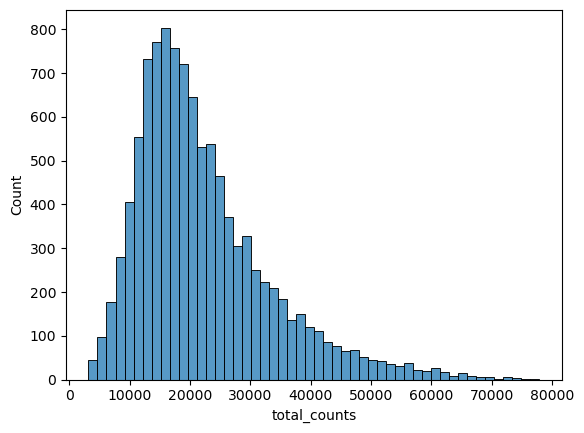

In [42]:
# Start by visualizing the distribution of total counts per cell to get an understanding of your data's distribution.
sns.histplot(combined_adata.obs['total_counts'], bins=50)

In [43]:
# Often, researchers use the median or mean total count across all cells as the target_sum. This ensures that the normalization doesn't excessively scale up very low-count cells or scale down very high-count cells.
mean_counts = combined_adata.obs['total_counts'].mean()
median_counts = combined_adata.obs['total_counts'].median()
median_counts

19506.5

In [104]:
#sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.normalize_total(combined_adata, target_sum=median_counts)

### Batch effect correction

#### Not implemented

In [444]:
# harmonypy, on the other hand, is designed to adjust high-dimensional data to minimize technical variance, such as batch effects.

In [445]:
combined_adata.obs

,condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pct_cmo,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
barcode,,,,,,,,,,,,,,,,
AACCTTTTCAGACCCG-1,CTRL_1,3530,8.169336,9860,9.196343,64.370650,68.851508,73.371036,79.693542,52.339520,215,5.375278,2.180527,963,6.871091,9.766734
AAGACAATCGAGTGGA-1,CTRL_1,5127,8.542471,17962,9.796069,41.268138,48.450245,55.327552,64.926591,22.890015,796,6.680855,4.431578,1615,7.387709,8.991204
AATCACGAGCGATGAC-1,CTRL_1,4905,8.498214,19456,9.875962,46.217105,53.274854,60.877193,70.639620,28.888889,486,6.188264,2.497944,1935,7.568379,9.945518
AATGACCGTTAATCGC-1,CTRL_1,3432,8.141190,8503,9.048292,56.134604,60.169744,64.592019,72.394282,36.695950,247,5.513429,2.904857,512,6.240276,6.021404
AATTTCCTCAGGACGA-1,CTRL_1,3771,8.235361,13410,9.503831,48.375939,55.666649,63.119494,72.874669,27.525266,608,6.411818,4.533930,1293,7.165493,9.642058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACGTTCAAGGCTT-1,TGFb1_GEM_2,4477,8.406932,14130,9.556126,44.846912,50.814738,57.415672,67.151012,26.673586,279,5.634790,1.974522,1206,7.095893,8.535032
TTTACTGCAGCTACAT-1,TGFb1_GEM_2,5677,8.644354,20994,9.952040,47.396076,52.451575,58.191089,67.294718,34.726238,294,5.686975,1.400400,1405,7.248504,6.692388
TTTCACATCGATGCAT-1,TGFb1_GEM_2,2748,7.918992,5458,8.605021,60.567966,64.664918,69.295469,76.666365,50.637605,90,4.510860,1.648956,484,6.184149,8.867717


In [446]:
adata = combined_adata

In [447]:
sc.pp.log1p(adata)

In [448]:
sc.tl.pca(adata)

/home2/lumpi/miniconda3/envs/scanpy-env3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


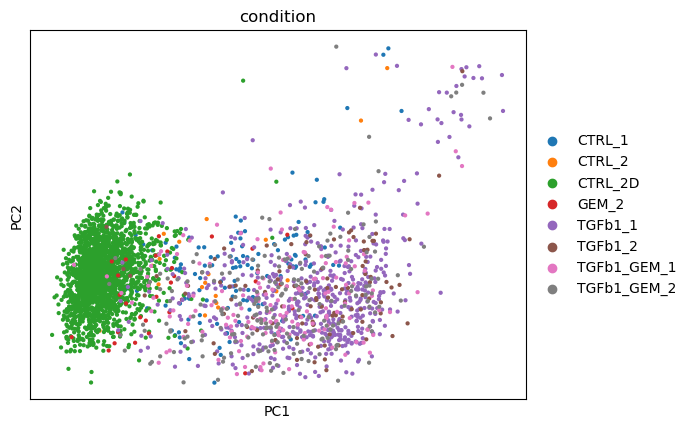

In [449]:
sc.pl.pca(adata, color='condition')

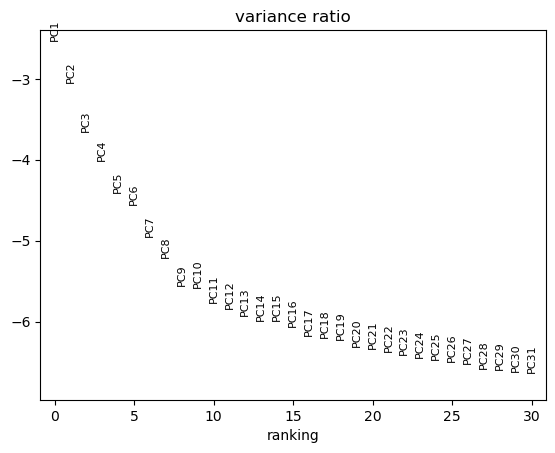

In [117]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# Use harmonypy for batch correction


In [ ]:
# Documentation1 https://github.com/slowkow/harmonypy
from harmonypy import run_harmony
integrated_data = run_harmony(adata.X, adata.obs, 'batch_column_in_obs')

In [30]:
# Documentation 2
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html

In [ ]:
import scanpy as sc
import scanpy.external as sce

In [ ]:
sce.pp.harmony_integrate(adata, 'condition')

In [ ]:
'X_pca_harmony' in adata.obsm


In [ ]:
sc.pl.pca(adata, color='condition')

### Log transformation

In [45]:
combined_adata

AnnData object with n_obs × n_vars = 10594 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo'

In [46]:
import numpy as np
import scanpy as sc

# Check for large integers (e.g., > 50) in the data matrix
large_integers = (combined_adata.X > 50).sum()

# If there are any large integers, it's likely not log-transformed
if large_integers > 0:
    sc.pp.log1p(combined_adata)
else:
    print("Data seems to be already log-transformed. No transformation applied.")

In [47]:
#sc.pp.log1p(combined_adata)

### Gene Dispersion Filtering Not used

In [624]:
# Gene dispersion filtering helps in filtering out genes that are not informative for the clustering.


In [625]:
combined_adata

AnnData object with n_obs × n_vars = 10594 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'

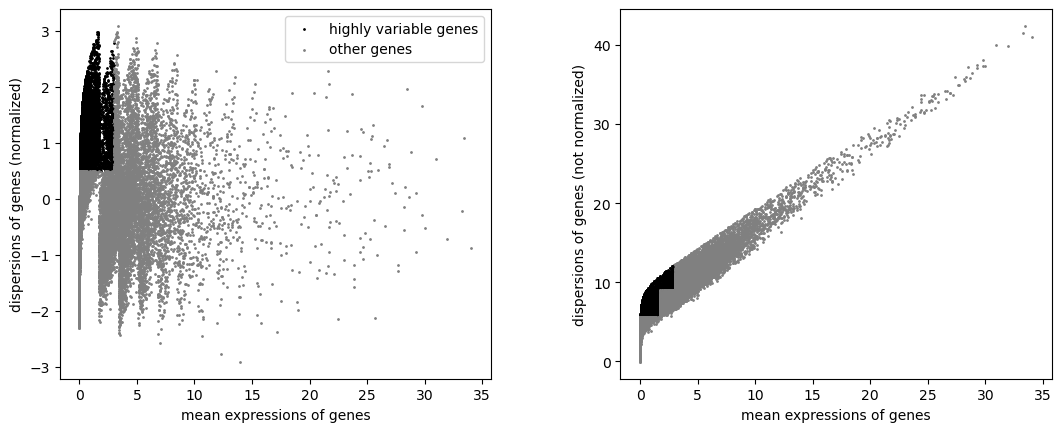

In [626]:
# In Scanpy, the calculation of dispersion and the selection of highly variable genes is often combined into a single function
# To compute and visualize the gene dispersions, you would typically use the highly_variable_genes function and then visualize the results
# Calculate highly variable genes
sc.pp.highly_variable_genes(combined_adata, min_disp=0.5)

# Visualize the results
sc.pl.highly_variable_genes(combined_adata)

In [320]:
combined_adata

AnnData object with n_obs × n_vars = 10837 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [263]:
# filter the dispersion
# not used: to harsh filtering

new_value = 0.5

# filter highly variable genes (genes with high dispersion)
sc.pp.filter_genes_dispersion(combined_adata, min_disp=new_value)

# remove non highly variable genes from the adata object (not used)
#combined_adata = combined_adata[:, combined_adata.var['highly_variable']]

In [321]:
combined_adata

AnnData object with n_obs × n_vars = 10837 × 36601
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### Highly Variable Gene Selection

In [788]:
# Identifying and focusing on highly variable genes improves the sensitivity of detecting cell populations.
#sc.pp.highly_variable_genes(combined_adata, flavor='cell_ranger', n_top_genes=2000)
sc.pp.highly_variable_genes(combined_adata, n_top_genes=2000)

In [789]:
# Determine a highly variable gene adata object
hvg_adata = combined_adata[:, combined_adata.var.highly_variable]

In [790]:
hvg_adata

View of AnnData object with n_obs × n_vars = 10594 × 2000
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_cmo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'CMO', 'gene_symbol', 'mito', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

/home2/lumpi/miniconda3/envs/scanpy-env3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


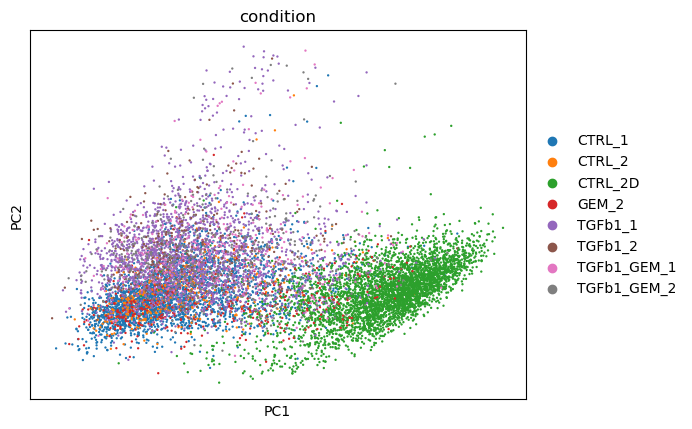

In [791]:
#sc.tl.pca(combined_adata)
sc.tl.pca(combined_adata, use_highly_variable=False)
sc.pl.pca(combined_adata, color='condition')

/home2/lumpi/miniconda3/envs/scanpy-env3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


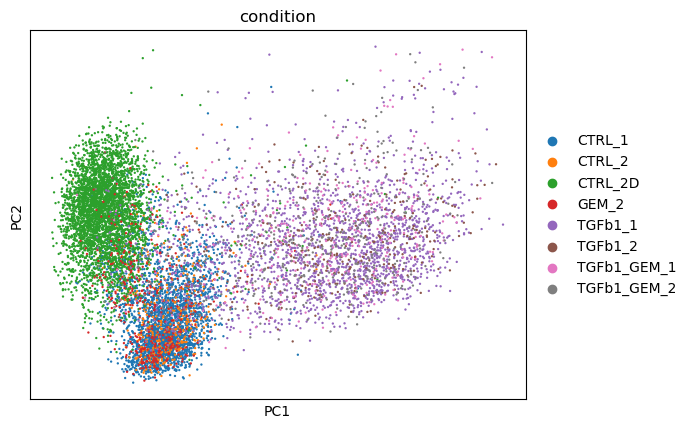

In [792]:
sc.tl.pca(hvg_adata)
sc.pl.pca(hvg_adata, color='condition')

### Visualize QC results

In [525]:
# Save the filtered and preprocessed data
#combined_adata.write('/storage/users/data/PANC/filtered_preprocessed_data.h5ad')
combined_adata.write('/storage/users/data/PANC/filtered_preprocessed_combined_adata.h5ad')

In [808]:
combined_adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000274175', 'ENSG00000275869', 'ENSG00000273554',
       'ENSG00000278782', 'ENSG00000277761', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', name='feature_id', length=36601)

In [805]:
named_adata = combined_adata.copy()

In [806]:
named_adata.var_names = named_adata.var['gene_symbol']

In [807]:
named_adata.var_names

CategoricalIndex(['MIR1302-2HG', 'FAM138A', 'OR4F5', '', '', '', '', '', '',
                  '',
                  ...
                  '', '', '', nan, nan, '', '', '', '', ''],
                 categories=['', 'A1BG', 'A1BG-AS1', 'A1CF', ..., 'ZZEF1', 'ZZZ3', 'hsa-mir-423', 'hsa-mir-1253'], ordered=False, dtype='category', name='gene_symbol', length=36601)

In [809]:
unique_var_names_count = combined_adata.var_names.nunique()
print(unique_var_names_count)

36601


In [810]:
unique_var_names_count = named_adata.var_names.nunique()
print(unique_var_names_count)

25303


In [813]:
named_hvg_adata = hvg_adata.copy()

In [814]:
named_hvg_adata.var_names = named_hvg_adata.var['gene_symbol']

/home2/lumpi/miniconda3/envs/scanpy-env3/lib/python3.9/site-packages/anndata/_core/anndata.py:879: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', '', 'C1QTNF12', 'TNFRSF9']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


#### Visualize for combined_adata 

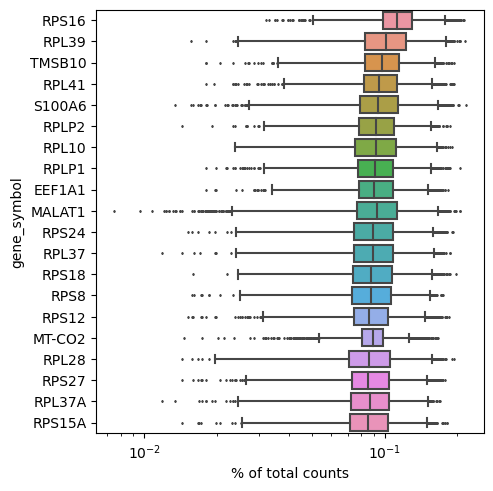

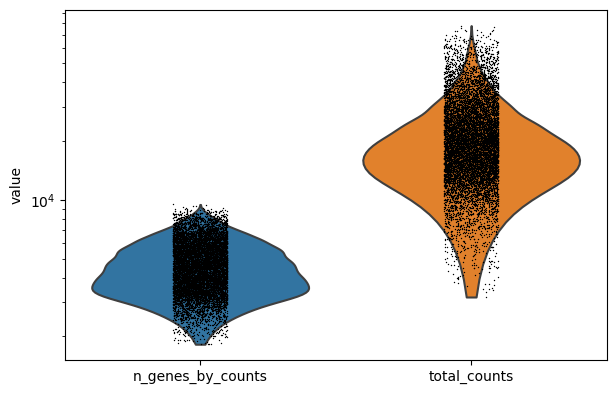

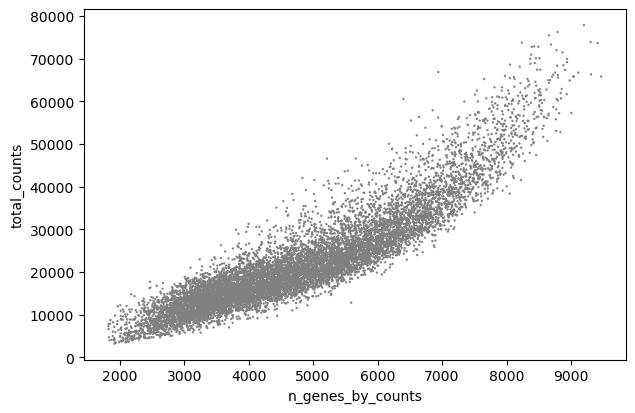

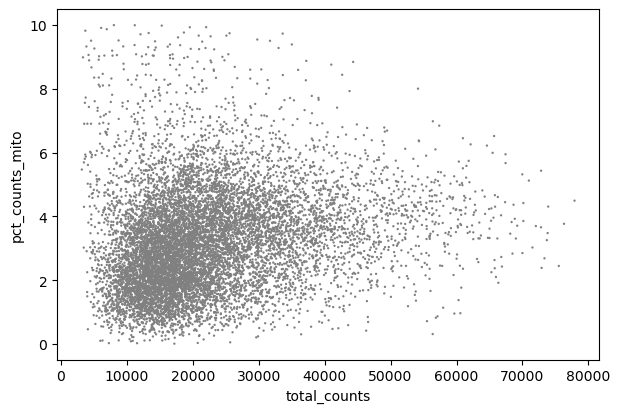

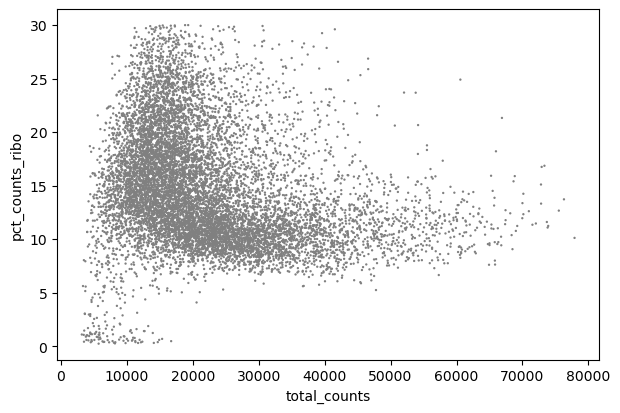

In [811]:
sc.pl.highest_expr_genes(named_adata, n_top=20, log=True, save='_qc.png')
sc.pl.violin(combined_adata, keys=['n_genes_by_counts', 'total_counts'], jitter=True, log=True, save='_qc.png')
sc.pl.scatter(combined_adata, x='n_genes_by_counts', y='total_counts', save='_qc.png')
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_mito', save='_qc.png')
sc.pl.scatter(combined_adata, x='total_counts', y='pct_counts_ribo', save='_qc.png')


#### Visualize for HVG combined_adata

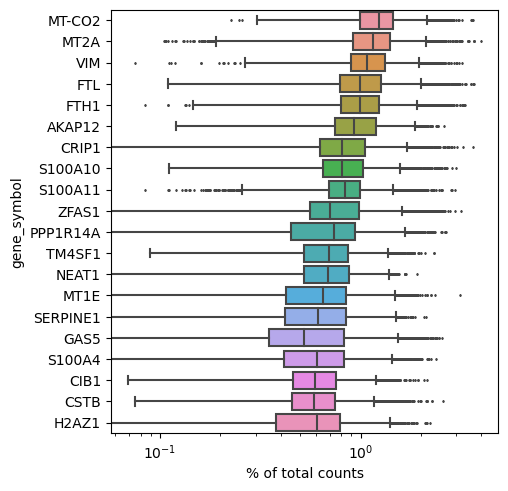

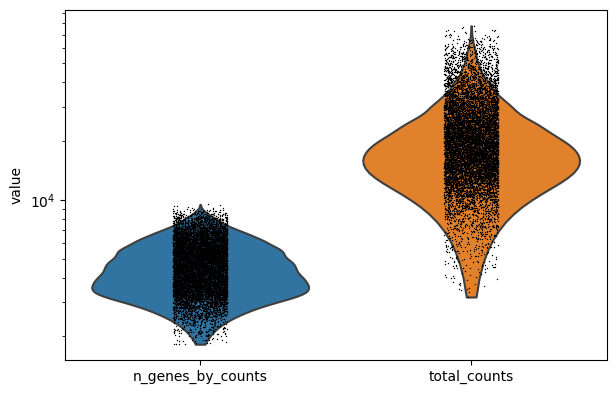

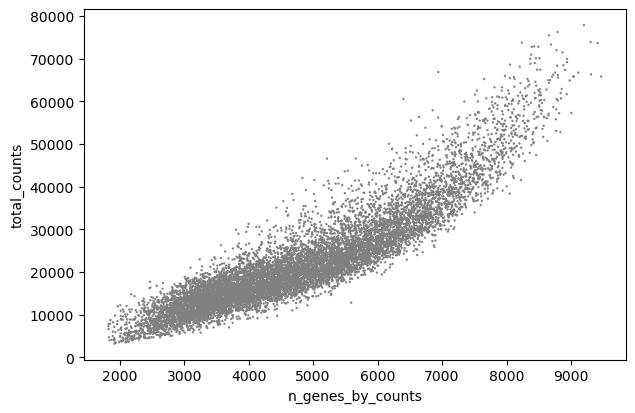

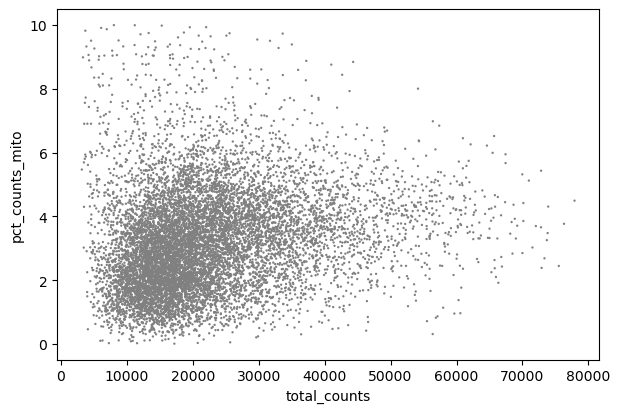

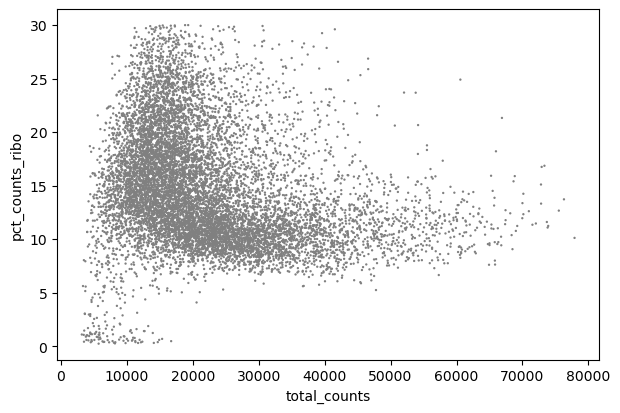

In [815]:
sc.pl.highest_expr_genes(named_hvg_adata, n_top=20, log=True, save='_qc.png')
sc.pl.violin(hvg_adata, keys=['n_genes_by_counts', 'total_counts'], jitter=True, log=True, save='_qc.png')
sc.pl.scatter(hvg_adata, x='n_genes_by_counts', y='total_counts', save='_qc.png')
sc.pl.scatter(hvg_adata, x='total_counts', y='pct_counts_mito', save='_qc.png')
sc.pl.scatter(hvg_adata, x='total_counts', y='pct_counts_ribo', save='_qc.png')

In [816]:
hvg_adata.write('/storage/users/data/PANC/hvg_adata.h5ad')